In [1]:
import os

In [4]:
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir="./data"
os.makedirs(data_dir,exist_ok=True)




ModuleNotFoundError: No module named 'torch_sparse'

In [3]:
print(torch. __version__)


1.13.0+cpu


In [6]:
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir="./data"
os.makedirs(data_dir,exist_ok=True)

In [7]:
dataset=Planetoid(root=data_dir,name='Cora')

Processing...
Done!


In [8]:
data=dataset[0]

In [9]:
print(f'Number of nodes: {data.num_nodes}')

Number of nodes: 2708


In [10]:
print(f'Number of edges: {data.num_edges}')

Number of edges: 10556


In [11]:
# there are no nodes not connected by edges
print(f'Has isolated nodes: {data.has_isolated_nodes()}')

Has isolated nodes: False


In [12]:
# there are no self-loops
print(f'Has self-loops: {data.has_self_loops()}')

Has self-loops: False


In [13]:
# the third line of code shows that edges are not directional that means the edge count is double the actual count because of the bi-directional edge information included
print(f'Is undirected: {data.is_undirected()}')

Is undirected: True


In [14]:
# how edge information is stored
# the edge held by the 30th node as an example

edge_index=data.edge_index.numpy()
print(edge_index)

[[   0    0    0 ... 2707 2707 2707]
 [ 633 1862 2582 ...  598 1473 2706]]


In [15]:
edge_example=edge_index[:,np.where(edge_index[0]==30)[0]]

In [16]:
edge_example

array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]], dtype=int64)

In [17]:
# draw a network centered on this node
node_example=np.unique(edge_example.flatten())
plt.figure(figsize=(10,6))
G=nx.Graph()

<Figure size 720x432 with 0 Axes>

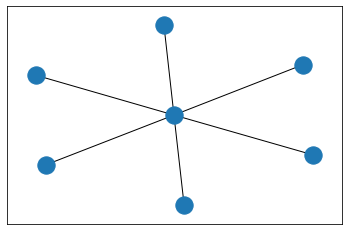

In [18]:
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0],edge_example[1])))
nx.draw_networkx(G,with_labels=False)

In [19]:
# Degree in graph theory means the number of edges joining a vertex(node) in a graph
# How many edges does each node have on average
print(f'Average node degree: {data.num_edges/data.num_nodes: .2f}')


Average node degree:  3.90


In [20]:
# we found that the average node degree is 3.9, pretty low. we can check the overall distribution by drawing a histogram of the degree

G=to_networkx(data,to_undirected=True)
degrees=[val for (node,val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


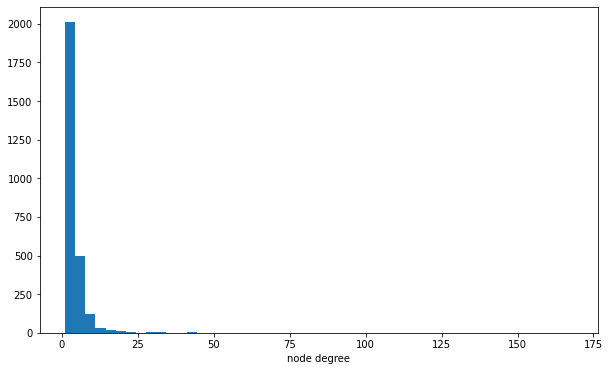

In [21]:
plt.figure(figsize=(10,6))
plt.hist(degrees,bins=50)
plt.xlabel("node degree")
plt.show()

In [22]:
# summarize A high degree means that they are connected to many nodes(papers)
# nodes with high degrees are likely to be important

In [32]:
# find the 10 nodes with the highest degree are located
G=to_networkx(data,to_undirected=True)
pos=nx.spring_layout(G,seed=42)

cent=nx.degree_centrality(G)
node_size=list(map(lambda x: x*500,cent.values()))

cent_array=np.array(list(cent.values()))
threshold=sorted(cent_array,reverse=True)[10]
print("threshold",threshold)
cent_bin=np.where(cent_array>=threshold,1,0.1)

plt.figure(figsize=(12,12))
nodes=nx.draw_networkx_nodes(G,pos,node_size=node_size,cmap=plt.cm.plasma,node_color=cent.bin,nodelist=list(cent.keys()),alpha=cent_bin)
edges=nx.draw_networkx_edges(G,pos,width=0.25,alpha=0.3)
plt.show()

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'